#Wavenet

See whitepaper [WAVENET: A GENERATIVE MODEL FOR RAW AUDIO](https://arxiv.org/pdf/1609.03499)

Our original implementation embeds single character and concatenate them (3 of them in our example). With such embedding, we are crushing too much information way too fast. This only uses low-level information of the input, so it doesn't matter how deep we make the hidden layers, it won't get much better results.

The Wavenet idea is similar to conv net, where in first layer, you input single characters, next layer use bigrams, next uses 4-grams, and so on. So it can extract high-level information and the result is lower loss and higher efficiency.

# Prepare

In [2]:
!wget "https://github.com/romenlaw/NaiveNeuralNetwork/blob/main/names.txt?raw=True" -O names.txt

--2024-08-28 22:38:25--  https://github.com/romenlaw/NaiveNeuralNetwork/blob/main/names.txt?raw=True
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/romenlaw/NaiveNeuralNetwork/raw/main/names.txt [following]
--2024-08-28 22:38:25--  https://github.com/romenlaw/NaiveNeuralNetwork/raw/main/names.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/names.txt [following]
--2024-08-28 22:38:25--  https://raw.githubusercontent.com/romenlaw/NaiveNeuralNetwork/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
len(words), max([len(w) for w in words]), words[:8]

(32033,
 15,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [5]:
vocab = sorted(list(set(''.join(words))))
vocab.insert(0, '.')
vocab_size = len(vocab)
itos={i:s for i, s in zip(range(vocab_size), vocab)}
stoi={s:i for i, s in zip(range(vocab_size), vocab)}

In [21]:
# build datasets: 80% training, 10% validation, 10% testing
import random
random.seed(42)
random.shuffle(words) # shuffle is in-place


block_size=8 # for wavenet we change it from 3 to 8.
X, Y = [], []
context = []
for w in words:
  context = [0] * block_size # context contains indices
  for c in (w + '.'):
    ix = stoi[c]
    X.append(context)
    Y.append(ix)
    #print(''.join([itos[i] for i in context]) + ' ---> ' + c)
    if c=='.':
      break
    context = context[1:] + [ix]

n1 = int(len(X)*.8)
n2 = int(len(X)*.9)
X_train = torch.tensor(X[:n1])
Y_train = torch.tensor(Y[:n1])
X_val = torch.tensor(X[n1:n2])
Y_val = torch.tensor(Y[n1:n2])
X_test = torch.tensor(X[n2:])
Y_test = torch.tensor(Y[n2:])

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 8]),
 torch.Size([182516]),
 torch.Size([22815, 8]),
 torch.Size([22815]),
 torch.Size([22815, 8]),
 torch.Size([22815]))

In [22]:
X_val[:5], Y_val[:5]

(tensor([[ 0,  4,  9,  1, 13,  1, 14, 20],
         [ 4,  9,  1, 13,  1, 14, 20,  5],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0, 10],
         [ 0,  0,  0,  0,  0,  0, 10,  1]]),
 tensor([ 5,  0, 10,  1, 14]))

# MLP

## torchified classes

In [135]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    """with Wevenet, the dim can be 2-dimensional.
    """
    self.eps=eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    """with Wavenet, x can be 3-dimensional (B,V,C), instead of 2 (B,V*C).
    for 3-dim x, we want to do the mean and var along the 1st 2 dimensions,
    i.e. x.view(-1, last_dim).mean(dim=0, keepdim=True)
    torch's mean can specify the dim as tuple, so we can use (0,1) as the dim
    when calling mean, and achieve the same.
    """
    if self.training:
      if x.ndim==2:
        dim=0
      if x.ndim==3:
        dim=(0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
      with torch.no_grad():
        self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
        self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
    else:
      xmean = self.running_mean
      xvar = self.running_var

    x_hat = (x - xmean) / (xvar + self.eps)**0.5
    self.out = self.gamma * x_hat + self.beta

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class FlattenConsecutive: # rename to distinguish from torch's Flatten, which does different things
  def __init__(self, n):
    """n is number of characters to concatinate - i.e. block_size.
    e.g. if input is (32, 8, 10), and n=8, then returns (32, 80)
         if n=2 (i.e. bigram), then return (32, 4, 20)
    """
    self.n = n

  def __call__(self, x):
    # B=batch_size, V=vocab_size, C=number of embed dimension
    B, V, C = x.shape
    x = x.view(B, V//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out=x
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    """num_embeddings is the vocab size,
    embedding_dim is the dimension of the embedded vector
    """
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# mimic torch.nn.Sequential
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)

    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

## initialisation

In [136]:
torch.manual_seed(42)

emb_dim = 24 # 10
hidden_dim = 128 # choose 68 because totol #param is roughly the same as before

model = Sequential([ Embedding(vocab_size, emb_dim),
    # we feed bi-grams int Linear layers instead of block_size of 8:
    FlattenConsecutive(2), Linear(emb_dim*2, hidden_dim, bias=False), BatchNorm1d(hidden_dim), Tanh(),
    FlattenConsecutive(2), Linear(hidden_dim*2, hidden_dim, bias=False), BatchNorm1d(hidden_dim), Tanh(),
    FlattenConsecutive(2), Linear(hidden_dim*2, hidden_dim, bias=False), BatchNorm1d(hidden_dim), Tanh(),
    Linear(hidden_dim, vocab_size) # output layer
])
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # make output layer less confident(ly wrong)

parameters = model.parameters()
for p in parameters:
  p.requires_grad=True
print(sum(p.nelement() for p in parameters))

76579


In [24]:
emb_dim*block_size * hidden_dim + hidden_dim*2 + hidden_dim*vocab_size +vocab_size+ vocab_size * emb_dim

22097

## playground - dissecting the layers

let's look at our MLP layer by layer

In [93]:
# construct a mini-batch of 4 samples
ix = torch.randint(0, X_train.shape[0], (4,))
Xb, Yb = X_train[ix], Y_train[ix]
logits = model(Xb)
Xb.shape, Xb # the batch has 4 samples, each sample is 8-characters

(torch.Size([4, 8]),
 tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0, 15,  1, 11, 12],
         [ 0,  0, 18,  1, 25, 13, 15, 14],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]))

In [129]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape) )

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [32]:
model.layers[0].out.shape # after embedding layer - each character is 10-dim vector

torch.Size([4, 8, 10])

In [33]:
model.layers[1].out.shape # flatten layer stretches the last 2-dim into one dim

torch.Size([4, 80])

In [34]:
model.layers[2].out.shape # output of Linear layer

torch.Size([4, 200])

In [35]:
# the linear layer is basically doing this:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [36]:
# the linear layer works even if we change the input sample's dimension,
# as long as the last dim matches the Linear's fan-in, it's fine.
# the multiplication is only happening to the last dim of the input sample.
(torch.randn(4, 2,5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 2, 5, 200])

In [40]:
t1 =[[[1,1], [1,1], [1,1]],
     [[1,1], [1,1], [1,1]]
     ]
torch.tensor(t1) @ torch.tensor([[2], [2]])

tensor([[[4],
         [4],
         [4]],

        [[4],
         [4],
         [4]]])

knowing the above, we want to group our 8-char context into bi-grams (1 2) (3 4) (5 6) (7 8)
and process them in parallel. So instead of (4,80) into the Linear, we want (4,4,20).

In [46]:
# python way of getting even/odd elements of a list:
odds = list(range(10))[1::2]
evens = list(range(10))[::2]
evens, odds

([0, 2, 4, 6, 8], [1, 3, 5, 7, 9])

In [55]:
torch.cat((torch.tensor([evens]), torch.tensor([odds])), dim=0), torch.cat((torch.tensor([evens]), torch.tensor([odds])), dim=1)

(tensor([[0, 2, 4, 6, 8],
         [1, 3, 5, 7, 9]]),
 tensor([[0, 2, 4, 6, 8, 1, 3, 5, 7, 9]]))

In [57]:
#similarly if we do it to our tensor
e = torch.randn(4, 8, 10)
explicit = torch.cat( (e[:,::2,:], e[:, 1::2, :]), dim=2)
explicit.shape # now we have 4 pairs of bigrams

torch.Size([4, 4, 20])

In [69]:
# the equivalent way in torch:
(e.view(4,4,20) == explicit).all()

tensor(True)

In [104]:
# let's have a look at the BN, where mean and var are calculated
e = torch.randn((4,3,2))
e

tensor([[[ 0.4248, -2.5431],
         [-1.6032, -0.7707],
         [-0.0541,  0.3592]],

        [[ 0.9253, -0.4704],
         [ 1.2161,  0.8585],
         [-0.6704,  0.1230]],

        [[ 0.0563, -1.9198],
         [ 0.8685, -0.1508],
         [ 0.5380,  0.4862]],

        [[-0.3117,  1.2374],
         [ 0.3144,  1.0599],
         [-0.7855, -1.2425]]])

In [107]:
e.mean((0,1)), e.mean((0,1), keepdim=True)

(tensor([ 0.0765, -0.2477]), tensor([[[ 0.0765, -0.2477]]]))

In [111]:
e.view(-1, 2).mean(dim=0), e.view(-1, 2).mean(dim=0, keepdim=True)

(tensor([ 0.0765, -0.2477]), tensor([[ 0.0765, -0.2477]]))

## training

In [137]:
max_steps=200000
batch_size=32
lossi=[]

for step in range(max_steps):
  # create mini_batch
  ix = torch.randint(0, X_train.shape[0], size=(batch_size,))
  Xb, Yb = X_train[ix], Y_train[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad=None
  loss.backward()

  # update
  lr = 0.1 if step<150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if step % 10000 ==0:
    print('%7d/%7d: %2.10f' % (step, max_steps, loss))
  lossi.append(loss.item())

  #break
print('%7d/%7d: %2.10f' % (step, max_steps, loss))

      0/ 200000: 3.3002052307
  10000/ 200000: 1.9523477554
  20000/ 200000: 2.1878404617
  30000/ 200000: 1.7295354605
  40000/ 200000: 2.2642648220
  50000/ 200000: 2.0725338459
  60000/ 200000: 2.2103981972
  70000/ 200000: 2.1886646748
  80000/ 200000: 1.5598725080
  90000/ 200000: 1.8700159788
 100000/ 200000: 2.2238843441
 110000/ 200000: 1.7486177683
 120000/ 200000: 2.0120618343
 130000/ 200000: 2.0910420418
 140000/ 200000: 1.9111864567
 150000/ 200000: 1.5432679653
 160000/ 200000: 1.8756422997
 170000/ 200000: 1.8333473206
 180000/ 200000: 1.5759855509
 190000/ 200000: 1.8748409748
 199999/ 200000: 1.8513283730


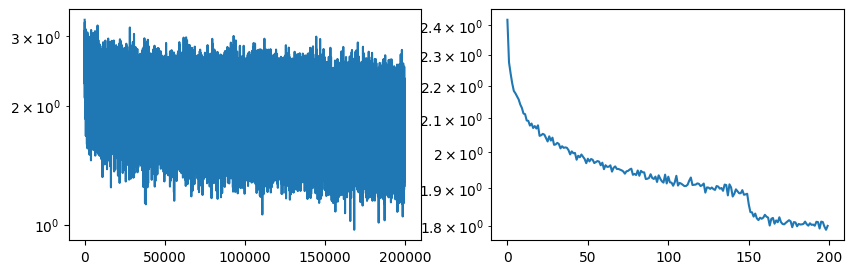

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(lossi)
ax1.set_yscale('log')
ax2.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
ax2.set_yscale('log')

## validate

In [139]:
for layer in model.layers:
  layer.training = False

@torch.no_grad()
def split_loss(s):
  """s is one of 'train', 'val', 'test'
  """
  xs, ys = { 'train': (X_train, Y_train),
          'val': (X_val, Y_val,),
           'test': (X_test, Y_test)}[s]
  # forward pass
  logits = model(xs)
  loss = F.cross_entropy(logits, ys)
  print(s, loss.item())

split_loss('train')
split_loss('val')

train 1.7658323049545288
val 1.9940435886383057


* the loss using the original impl of 3-character concatenation and hidden layer of 200 dim is comparable to previous exercises: about 2.06-2.1
* using the same config as above but with 8-character concatenation, the loss is about 1.9-2.03
* using the wavenet (with wrong BN) loss is the same 1.94-2.35
* after fixing BN, loss is 1.9-2.03, and the inference result seems better than pervious one.
* wavenet using emb_dim=24, hidden_dim=128 the loss is 1.76-1.994

## Sample

In [140]:
with torch.no_grad():
  for _ in range(20):
    out=[]
    context=[0]*block_size

    while True:
      logits = model(torch.tensor([context]))

      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1)
      context = context[1:]+[ix]
      out.append(ix.item())
      if ix==0:
        break
    print(''.join(itos[i] for i in out))

aiyanah.
giuson.
jenson.
liba.
rayna.
torre.
reiles.
kendley.
kannia.
sond.
laylor.
shawn.
denice.
myndaled.
coheb.
petrik.
isabella.
jayson.
lanaie.
manaswa.
